# Semi-Automated Protected Attributes Detection through Sample/Label Biases

<br>

In [ ]:
import math
import itertools
import fairlens as fl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import quantecon as qe
import statsmodels.api as sm

from IPython.display import display

from packages.imbalance_degree import imbalance_degree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from sklearn.datasets import fetch_openml
from scipy.stats import entropy, pearsonr, chi2_contingency, pointbiserialr
from statsmodels.stats.oneway import effectsize_oneway
from statsmodels.formula.api import ols
from scipy.stats.contingency import association
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATASETS = [
    43141,   # ACS                                      JOB/INCOME
    46356,   # German credit data                       FINANCE
    45069,   # Diabetes                                 HEALTH
    43904,   # Law                                      EDUCATION
 ]

<br>

### Metrics Overview

<br>

**Entropy**

Entropy is a metric often used in the context of information theory and machine learning to measure the impurity or disorder in a dataset. In classification tasks, entropy quantifies the uncertainty associated with class labels. It's commonly used to evaluate the effectiveness of splitting data based on a particular attribute.

Reference to entropy metric and related equation:

* https://ieeexplore.ieee.org/abstract/document/6773024

Reference from **scipy.stats** [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html):

* Calculate the Shannon entropy/relative entropy of given distribution(s). <br>If only probabilities pk are given, the Shannon entropy is calculated as H = -sum(pk * log(pk)). By the default, log base is set to e (natural logarithm).

Following entropy value interpretations are based from the book [Elements of information theory](https://eee.guc.edu.eg/Courses/Communications/COMM1003%20Information%20Theory/Solution_Manual.pdf) written by Cover, Thomas M., and Joy A. Thomas in 2006:

* The values represent information entropy measured in nats (short for natural units of information), rather than bits (base 2 logarithmic scale).

    * Range of Entropy Values (0 to 1):
    
        * In a natural logarithmic scale, entropy values typically range from 0 to 1 nats. An entropy of 0 nats indicates that the data source is completely predictable, with no uncertainty or randomness. This means one has perfect knowledge of the data. As entropy increases, it indicates increasing uncertainty and randomness in the data source. 
    
    * Low Entropy (Close to 0 nats):
        * When entropy is close to 0 nats, it means that the information source or dataset is highly ordered and predictable in a natural logarithmic context. For example, if one has a dataset of events that always occur in a consistent pattern, the entropy in nats would be close to 0.
    
    * Moderate Entropy (Between 0 and 1 nats):
        * Entropy values between 0 and 1 nats represent varying degrees of uncertainty or randomness in a natural logarithmic context. For example, if one has a dataset of events that occur with some degree of unpredictability, the entropy in nats would be moderate.
        
     * High Entropy (Close to 1 nats):
         * When entropy is close to 1 nats, it means that the information source or dataset is highly unpredictable and random in a natural logarithmic context. For example, if one has a dataset of events that occur randomly and with equal probability, the entropy in nats would be close to 1.

<br>

**Imbalance Ratio**

Imbalance Ratio is a class-imbalance extent metric that considers both the class distribution and the dimensionality of an imbalanced dataset. It is the most commonly used measure to describe the imbalance extent of a dataset:

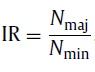

where N<sub>maj</sub> is the sample size of the majority class and N<sub>min</sub> is the sample size of the minority class. When there are multi-classes, i.e. the number of classes is larger than 2, N<sub>maj</sub> is the sample size of the largest majority class and N<sub>min</sub> is the sample size of the smallest minority class. It is clear that when IR = 1 , we have an exactly balanced dataset. When IR > 1, the larger the IR, the larger the imbalance extent of the dataset.

Reference to imbalance ratio metric and related equation:

* https://www.sciencedirect.com/science/article/abs/pii/S0167865520300829?casa_token=ZtBYgYHMwrkAAAAA:7ljNGyKBpRWzEf5byZCjAC4ovozrEfdR7z2SMngMjHYyf0pWtaMjllRjnTWxrgGudZ6j0e5jVvIg

<br>

**Imbalance Degree**

The imbalance degree metric quantifies the extent of class imbalance in a multi-class or binary classification problem. It provides a single numerical value that represents the degree to which class distribution is skewed or imbalanced in the dataset. The metric is computed based on the proportions of instances belonging to different classes. A lower imbalance degree value suggests a more balanced distribution, while a higher value indicates a greater level of imbalance, where certain classes dominate the dataset in terms of representation.

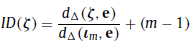

Reference to imbalance degree metric and related equation:

* https://www.sciencedirect.com/science/article/pii/S016786551730257X

**Statistical Parity Difference**

* Reference:
    * [Garg, Pratyush, et al. "Fairness metrics: A comparative analysis." 2020 IEEE, 2020.](https://ieeexplore.ieee.org/abstract/document/9378025?casa_token=imZhhCuHchAAAAAA:cvTOPdCJlBTyPABtIAARC6ll_tm1PtJpwkSK1LV9uvaZcMiGySAcAhq6Bfsf4qwtF7e3mgJlR9h8rA)

        * The base rate of a group is the ratio of people in the group who belong to the positive class (y = 1) to the total number of people in that group. Thus, having non-equal base rates across groups means p(y = 1|G = 0) = p(y = 1|G = 1). This assumption is to ensure that the analysis reflects group imbalance, which is typically present in practice.
    * [AIF 360 Documentation](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html#aif360.metrics.BinaryLabelDatasetMetric.base_rate)
        * Method Parameters: **privileged** (bool, optional) – Boolean prescribing whether to condition this metric on the <code>privileged_groupsy</code>, if <code>True</code>, or the <code>unprivileged_groups</code>, if <code>False</code>. Defaults to <code>None</code> meaning this metric is computed over the entire dataset.

**Disparate Impact Ratio**

* References: 
    * [Feldman, Michael, et al. "Certifying and removing disparate impact." 2015.](https://dl.acm.org/doi/abs/10.1145/2783258.2783311?casa_token=mgfTdMoZlmEAAAAA:X2WEkMRylcEdMPiqC7fvVM53uf7XfqbYyhHjZXfSF_FLrCITdhIURzGdCm3cxligj0-gcQUiAMpbLn0)
    * [Towards Data Science Article](https://towardsdatascience.com/ai-fairness-explanation-of-disparate-impact-remover-ce0da59451f1)
        * Disparate Impact is a metric to evaluate fairness. It compares the proportion of individuals that receive a positive output for two groups: an unprivileged group and a privileged group.
        <br><br>
        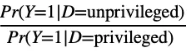
        <br><br>
        The calculation is the proportion of the unprivileged group that received the positive outcome divided by the proportion of the privileged group that received the positive outcome. The industry standard is a "4/5" rule: if the unprivileged group receives a positive outcome less than 80% of their proportion of the privileged group, this is a disparate impact violation.

**Smoothed Empirical Differential Fairness**

* References:
    * [J. R. Foulds, R. Islam, K. N. Keya, and S. Pan, “An Intersectional Definition of Fairness”, 2018](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101635)
    * [IBM documentation 1](https://dataplatform.cloud.ibm.com/docs/content/wsj/model/wos-smooth-empirical-diff.html?context=cpdaas#:~:text=The%20calculation%20produces%20a%20value,Parent%20topic%3A%20Fairness%20metrics%20overview)
    * [IBM documentation 2](https://www.ibm.com/docs/en/cloud-paks/cp-data/4.5.x?topic=tutorials-metrics-computation-using-python-sdk)
        * The Smoothed Empirical Differential (SED) metric is used to quantify fairness in model predictions by comparing the differential of smoothed probabilities between different groups within a dataset. Specifically, it evaluates the minimum ratio of Dirichlet smoothed probabilities for favorable and unfavorable outcomes between intersecting groups divided by certain features within the dataset. These intersecting groups are considered equal, meaning there are no designated privileged or unprivileged groups. The SED metric value ranges between 0 and 1, with the value representing the aforementioned minimum ratio
        * In terms of interpretation:
            * A value of 1 would indicate perfect fairness, as it signifies that the ratio of favorable to unfavorable outcomes is the same across all intersecting groups.
            * A value closer to 0 may indicate a disparity in the distribution of favorable and unfavorable outcomes among different intersecting groups, which could signify a lack of fairness.
    
    

<br>

In [ ]:
dataset_id = 0
bins = 3
dataset = fetch_openml(data_id=DATASETS[dataset_id], as_frame=True)
print(dataset.target_names)
df=dataset.data

In [ ]:
def categorize_target(target):
    if target<median:
        return 0
    if target >=median:
        return 1
    
if dataset_id==0:
    df.rename(columns={'MAR': 'Maritial status', 'RAC1P':'Race', 'AGEP':'Age', 'RELP':'Relationship', 'POBC':'Place of birth', 'SCHL':'School'}, inplace=True)
    median = dataset.target.median()
    dataset.target= dataset.target.apply(categorize_target)
    

if dataset_id==2:
    dataset.target = dataset.target.replace('>30', 0)
    dataset.target = dataset.target.replace('<30', 1)
    dataset.target = dataset.target.replace('NO', 0)

if dataset_id == 3:
    dataset.data['ugpagt3'] = dataset.target
    dataset.target = dataset.data["bar"]
    dataset.data.drop(columns=['bar'], inplace=True)
    df= dataset.data
    
df = df.replace('nan', np.nan)
df = df.dropna()       
        
df_copy = df.copy()
for c in df_copy.columns:
    df_copy[c] = df_copy[c].astype(str)
    
protected_attributes = list(fl.sensitive.detect_names_df(df_copy, deep_search=True).keys())
print("Detected protected attributes: ", protected_attributes)
if len(protected_attributes)==0:
    raise Exception("No found possible protected attributes. Check the dataset or the naming of the attributes.")

for pa in protected_attributes:     
    bins_age = 3
    if pa.lower() == 'age' and df[pa].dtypes == 'int64':
        df = df[df[pa] <= 100]
        df[pa] = pd.qcut(df[pa], q=bins_age)
        df[pa] = df[pa].astype('object')
    
    if df[pa].dtype == 'category':
        df[pa] = df[pa].astype('object')
        
    if df[pa].dtype != 'object':        
        if len(pd.unique(df[pa])) >= 10:
            df[pa] = pd.cut(df[pa], bins=bins)
        df[pa] = df[pa].astype('object')
        
for c in df.columns:
    if (df[c].dtype == 'category'):
        df[c] = df[c].astype('object')
    elif (len(pd.unique(df[c])) <= 5):
        df[c] = df[c].astype('object') 
        
    if (df[c].dtype == 'int64' or df[c].dtype == 'float64') and (len(pd.unique(df[c])) > 20):
        df[c] = pd.cut(df[c], bins=bins)
        df[c] = df[c].astype('object')

df.head()

<br>

## Sample Biases

<br>

### Data Normalization

In [ ]:
# normalize the data
numeric_data = df.select_dtypes(include=['int64', 'float64', 'uint8'])
categorical_data = df.select_dtypes(include=['object', 'category'])
try:
    categorical_data[dataset.target_names[0]] = dataset.target
except:
    # that means that target attribute is the last column in a dataframe
    pass
    
scaler = MinMaxScaler()
scaled_data = []
numerical_present = True
if numeric_data.columns.size > 0:
    scaled_data = scaler.fit_transform(numeric_data)
    # no numerical data present in the dataset 
    numerical_present = False
encoder = LabelEncoder()

try:
    encoded_data = categorical_data.apply(encoder.fit_transform)
    encoded_data[encoded_data.columns.tolist()] = encoded_data[encoded_data.columns.tolist()].astype(object)
    if numerical_present:
          data = encoded_data.reset_index(drop=True)
    else:
        data = pd.concat([pd.DataFrame(scaled_data, columns=numeric_data.columns), encoded_data.reset_index(drop=True)], axis=1)
    categorical_present = True
except:
    # no categorical attritbutes present in the observed dataset -> data = scaled numeric data
    categorical_present = False
    data = pd.DataFrame(scaled_data, columns=numeric_data.columns)

data = data.drop_duplicates()
data.head()


In [ ]:
if categorical_present:
    categorical_data = df.select_dtypes(include=['object', 'category'])
    
    try:
        categorical_data[dataset.target_names[0]] = dataset.target
    except:
        # last column is the target label/attribute
        pass

    for c in categorical_data.columns:
        le = LabelEncoder()
        le.fit(categorical_data[c])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

        print()
        print('Attribute: ' + c)
        print(le_name_mapping)
else:
    print('No categorical attributes found in the dataset!')

<br>

### (Hidden) Correlation

In [ ]:
significance_matrix = {}
correlation_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
for col1 in data.columns:
    for col2 in data.columns:
        if col1 != col2:
            if (data[col1].dtype == object and data[col2].dtype == object):
                # Chi2 test + Cramer's V test
                contingency_table = pd.crosstab(data[col1], data[col2])
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                
                if (p < 0.05):
                    cramers_v_value = association(contingency_table)
                    correlation_matrix.at[col1, col2] = cramers_v_value
                    significance_matrix[(col1, col2)] = p
            elif ((data[col1].dtype == object and data[col2].dtype != object) or
                  (data[col1].dtype != object and data[col2].dtype == object)):
                if (data[col1].dtype == object):
                    cat = data[col1]
                    numeric = data[col2]
                else:
                    cat = data[col2]
                    numeric = data[col1]
                    
                # One-Way ANOVA with effect size (multi-class categorical variable) -> omega squared effect size
                if (len(pd.unique(cat)) > 2):
                    q = data[[numeric.name, cat.name]]
                    q[cat.name] = pd.to_numeric(q[cat.name])
                    
                    model = ols('Q(\"' + numeric.name + '\")' + ' ~ C(Q(\"' + cat.name + '\"))', data=q).fit()
                    aov = sm.stats.anova_lm(model, typ=2)
                    
                    if (aov['PR(>F)'].iloc[0] < 0.05):
                        aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
                        aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
                        aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
                        correlation_matrix.at[col1, col2] = aov['omega_sq'].iloc[0]
                        significance_matrix[(col1, col2)] = aov['PR(>F)'].iloc[0]
                else:
                    # Point-Biserial (binary categorical variable)
                    pointbiserial_corr, pointbiserial_p_value = pointbiserialr(cat, numeric)
                    if (pointbiserial_p_value < 0.05):
                        correlation_matrix.at[col1, col2] = pointbiserial_corr
                        significance_matrix[(col1, col2)] = pointbiserial_p_value
            else:                
                # Pearson's correlation
                coef, p_value = pearsonr(data[col1], data[col2])
                if (p_value < 0.05):
                    correlation_matrix.at[col1, col2] = coef
                    significance_matrix[(col1, col2)] = p_value

# Get the DataFrame index and columns
index = correlation_matrix.index
columns = correlation_matrix.columns

# Extract elements below the main diagonal
below_main_diagonal = correlation_matrix.where(np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set index and columns for the extracted matrix
below_main_diagonal.index = index
below_main_diagonal.columns = columns

cmap = sns.diverging_palette(220, 20, as_cmap=True)
mask = pd.isna(below_main_diagonal)

# Create a heatmap using seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap=cmap, 
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max())
plt.title('Correlation Heatmap\n')
plt.show()

Omega square effect size calculation [source](https://www.pythonfordatascience.org/anova-python/#anova_statsmodels).

Explanations why <b>omega squared</b> effect size is better than the <u>eta squared</u> can be found [here](https://www.theanalysisfactor.com/effect-size/) and [here](https://lbecker.uccs.edu/glm_effectsize) as well as in [this journal paper](https://psycnet.apa.org/record/2023-92087-001) in more details.

<br>

In [ ]:
# siginificance matrix - dictionary holding all the significance tests results
significance_matrix

In [ ]:
q = below_main_diagonal.fillna(0).stack()

top_largest = q.nlargest(15)
top_smallest = q.nsmallest(5)

candidates = pd.concat([top_largest, top_smallest])
candidates = pd.DataFrame(candidates, columns=['corr'])
candidates['abs_corr'] = abs(candidates['corr']) 
candidates = candidates.sort_values(by='abs_corr', ascending=False)
candidates = candidates[candidates["corr"] != 0]

candidates = candidates['corr'].head(20)
candidates

In [ ]:
try:
    exclude = list(protected_attributes) + [dataset.target_names[0]]
except:
    exclude = list(protected_attributes) + [data.columns[-1]]

attribute_pairs = candidates.index.values.tolist()

result = pd.Series()
consumed_attributes = []
for i, attribute_pair in enumerate(attribute_pairs):
    att1 = attribute_pair[0]
    att2 = attribute_pair[1]

    if (att1 not in protected_attributes and att2 not in protected_attributes):
        continue
    if (att1 in exclude or att1 in consumed_attributes) and (att2 in exclude or att2 in consumed_attributes):
        continue    
    if (att1 not in exclude and att1 not in consumed_attributes):
        consumed_attributes.append(att1)
    if (att2 not in exclude and att2 not in consumed_attributes):
        consumed_attributes.append(att2)

    result = pd.concat([result, pd.Series(data={candidates.index[i]: candidates[i]})])

result

In [ ]:
significance_matrix[("fam_inc", "age")]

In [ ]:
q = pd.unique(list(itertools.chain.from_iterable(result.index.values.tolist())))
# attributes that are not sensitive but highly correlated with a sensitive attribute
focus_attributes = [a for a in q if a not in exclude]
print(focus_attributes)

<br>

### Metrics Report

In [ ]:
def calculate_entropy(series):
    unique_values = pd.unique(series)
    num_values = len(unique_values)
    
    if num_values == 1:
        return 0  # If there's only one unique value, entropy is 0
    
    if series.dtype == np.number:
        # Numerical attribute
        sorted_values = np.sort(unique_values)
        bins = [(sorted_values[i] + sorted_values[i+1]) / 2 for i in range(num_values - 1)]
        hist, _ = np.histogram(series, bins=bins)
        prob_distribution = hist / len(series)
    else:
        # Categorical attribute
        value_counts = series.value_counts()
        prob_distribution = value_counts / len(series)
    
    entropy_value = entropy(prob_distribution, base=num_values)
    return entropy_value

def calculate_imbalance_ratio(series):
    if (series.dtype == object or series.dtype == 'category'):
        # For both binary & multi-class categorical attributes (for multi-class the results are "low-resolution")
        class_counts = series.value_counts()
        return class_counts.max() / class_counts.min()
    else:
        return np.nan
    
def calculate_imbalance_degree(series, distance="EU"):
    if (series.dtype == object or series.dtype == 'category'):
        return imbalance_degree(series, distance)
    else:
        return np.nan
    
def get_minority_classes(series):
    """
    Minority classes are considered to be those with lower empirical_distribution 
    in comparisson to related attribute equiprobability
    """
    if series.dtype == object or series.dtype == 'category':
        unique_classes, class_counts = np.unique(series, return_counts=True)
        empirical_distribution = class_counts / class_counts.sum()
        
        eqp = 1 / len(class_counts) # equiprobability
        
        result = {unique_classes[i]:x for i, x in enumerate(empirical_distribution) if x < eqp}
        result = dict(sorted(result.items(), key=lambda item: item[1]))
        return list(result.keys())
    else:
        return np.nan
    
def get_majority_classes(series):
    """
    Majority classes are considered to be those with higher empirical_distribution 
    in comparisson to related attribute equiprobability
    """
    if (series.dtype == object or series.dtype == 'category'):
        unique_classes, class_counts = np.unique(series, return_counts=True)
        empirical_distribution = class_counts / class_counts.sum()  
        eqp = 1 / len(class_counts) # equiprobability
        result = {unique_classes[i]:x for i, x in enumerate(empirical_distribution) if x > eqp}
        result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
        return list(result.keys())        
    else:
        return np.nan
    
def get_attribute_label_encoder_mapping(attribute):
    le = LabelEncoder()
    le.fit(df[attribute])
    return dict(zip(le.classes_, le.transform(le.classes_))) 

def detect_protected_attributes(dataframe):
    stats = {}
    concentrations = [10000, 5000, 1000, 100, 10, 1]
    while(len(concentrations)):
        exit = True
        for attr in dataframe.columns:
            entropy_val = calculate_entropy(dataframe[attr])
            imbalance_ratio = calculate_imbalance_ratio(dataframe[attr])
            imbalance_degree = calculate_imbalance_degree(dataframe[attr])
            majority_classes = get_majority_classes(df[attr])   
            minority_classes = get_minority_classes(df[attr])

            base_rate_privileged = np.nan
            base_rate_unprivileged_all = np.nan
            disparate_impact_ratio_all = np.nan
            base_rate_unprivileged_list = np.nan
            disparate_impact_ratio_list = np.nan
            if (dataframe[attr].dtype == object or dataframe[attr].dtype == 'category'):
                label_names = dataset.target_names
                if len(label_names) == 0:
                    label_names = [data.columns[-1]]

                bld = BinaryLabelDataset(
                    df=data,
                    label_names=label_names,
                    protected_attribute_names=[attr],
                    favorable_label=1,
                    unfavorable_label=0)

                le_name_mapping = get_attribute_label_encoder_mapping(attr)            
                privileged_groups = [{attr: le_name_mapping[v]} for v in majority_classes]
                unprivileged_groups = [{attr: le_name_mapping[v]} for v in minority_classes]

                metric = BinaryLabelDatasetMetric(
                        bld, 
                        privileged_groups=privileged_groups,
                        unprivileged_groups=unprivileged_groups)

                base_rate_privileged_all = metric.base_rate(True)
                base_rate_unprivileged_all = metric.base_rate(False)
                statistical_parrity_difference_all = metric.statistical_parity_difference()
                disparate_impact_ratio_all = metric.disparate_impact()
                sedf = metric.smoothed_empirical_differential_fairness(concentrations[-1])

                if sedf > 1:
                    exit = False
                    concentrations.pop()
                    break

            if imbalance_degree is np.nan:
                total_classes = np.nan
            else:
                total_classes = len(pd.unique(dataframe[attr]))

            stats[attr] = {
                'majority_classes': majority_classes,
                'minority_classes': minority_classes,
                'total_classes': total_classes,
                'entropy': entropy_val,
                'imbalance_ratio': imbalance_ratio,
                'imbalance_degree': imbalance_degree,
                'statistical_parity_difference': statistical_parrity_difference_all,
                'disparate_impact_ratio': disparate_impact_ratio_all,
                'smoothed_edf': sedf
            }
        
        if exit:
            break
            
    print('Concentration parameter for Dirichlet smoothing: ' + str(concentrations[-1]))
    return pd.DataFrame(stats).transpose()

focus = protected_attributes + focus_attributes
print(focus)
stats = detect_protected_attributes(data[focus])
stats

yes<br>

<u>Interpretation of **entropy** values in the context of fairness:</u>
* Source: [Information Entropy (Medium article)](https://medium.com/@mhannan94/information-entropy-3cce2bac62a2)
    * Entropy is a measure of how much information a variable contains. When a low probability event occurs, it carries more information (“surprisal”) and a high probability event carries less information, because we are not as surprised that the event occurred. If a variable can only take a single value, the entropy of said variable is 0, because we know with complete certainty what value the variable will take. 

<u>Interpretation of **imbalanced degree (ID)** values (summary section from J. Ortigosa-Hernández et al. 2017):</u>
    
* (i) it is a single easy-readable real value in the range [0, K), where K is the number of classes

* (i+) For multi-class categorical variables the **equiprobability** value is important which says which of the labels are categorized as majority one and which as minority

* (ii) Empirical results show that imbalance-degree has a higher resolution and is more sensitive to express the hindrance that skewed class distributions cause in the traditional supervised algorithms than imbalance-ratio

        
<u>Interpretation of **imbalance degree** values in the context of fairness:</u>
    
In many cases, a higher imbalance degree can signal potential fairness or bias issues, but the interpretation can vary depending on the specific context. Here's how you can relate imbalance degree to fairness:

* High Imbalance Degree:
    * A higher imbalance degree typically indicates a significant disparity in the distribution of outcomes or attributes. In the context of fairness, this could mean that a particular group or category is disproportionately affected by certain outcomes, such as positive or negative outcomes. If the attribute with a high imbalance degree is a protected attribute (e.g., gender, race), it may indicate potential bias or discrimination in the system. For example, if one gender is much more likely to receive a certain outcome, this could be a sign of gender bias.
    
* Low Imbalance Degree:
    * A lower imbalance degree suggests a more balanced distribution of outcomes or attributes. In the context of fairness, this can indicate a fairer system where different groups or categories are more equally treated. However, it's important to note that low imbalance degree does not necessarily guarantee fairness. There can still be other forms of bias or fairness issues that are not captured by this measure.

* Interpretation Depends on Context:
    * The interpretation of imbalance degree always depends on the specific context and what you consider a fair or unbiased distribution. In some cases, a certain level of imbalance may be acceptable or even desirable if it reflects underlying differences in the population. To assess fairness comprehensively, you should consider various fairness metrics, domain-specific knowledge, and social, legal, and ethical considerations. It's not solely about the imbalance degree but also about the implications of that imbalance on different groups and individuals.

<br>

### Metrics Ranking

In [ ]:
# "higher is better" in the context how sensitive an attribute actually is 
# ranking score   -> the least sensitive attribute gets the best score (e.g., 1) for observed metric
# ranking overall -> the most sensitive attribute will have the highest sum of ranking scores, while
#                    the least sensitive the lowest sum of ranking scores
higher_is_better = {
    'entropy': True,                           # the higher the entropy, the less sensitive an attribute is
    'imbalance_ratio': False,                  # the higher the imbalance ratio, the more sensitive an attribute is
    'imbalance_degree': False,                 # the higher the imbalance degree, the more sensitive an attribute is
    'statistical_parity_difference': False,    # the higher the (absolute) statistical parity difference, the more sensitive an attribute is
    'disparate_impact_ratio': False,           # the higher the difference ("DIR - 1" observation), the more sensitive an attribute is (difference of 0 would indicate perfect fairness)
    'smoothed_edf': True                       # the higher the smoothed EDF, the less sensitive an attribute (value of 1 would indicate perfect fairness)
}

def calculate_rank(values):
    sorted_values = values.sort_values(ascending=not higher_is_better[metric])
    ranks = sorted_values.rank(method='dense', ascending=not higher_is_better[metric])
    return ranks

ranks = stats[stats.columns[3:]]

for metric in ranks.columns:
    if metric == 'disparate_impact_ratio':
        ranks[metric] = calculate_rank(abs(ranks[metric] - 1))
    elif metric == 'imbalance_degree':
        ranks[metric] = calculate_rank(ranks[metric] / stats['total_classes'])
    elif metric == 'statistical_parity_difference':
        ranks[metric] = calculate_rank(abs(ranks[metric]))
    else:
        ranks[metric] = calculate_rank(ranks[metric])
        
ranks = ranks.astype(int)
ranks

In [ ]:
distribution_metrics = ['entropy', 'imbalance_ratio', 'imbalance_degree']
aif360_metrics = ['statistical_parity_difference', 'disparate_impact_ratio', 'smoothed_edf']

dist_rankings = pd.DataFrame(ranks[distribution_metrics].sum(axis=1).sort_values(ascending=False), columns=['RS*'])
dist_rankings['R*'] = list(range(1, len(dist_rankings) + 1))

aif360_rankings = pd.DataFrame(ranks[aif360_metrics].sum(axis=1).sort_values(ascending=False), columns=['RS**'])
aif360_rankings['R**'] = list(range(1, len(aif360_rankings) + 1))

rankings_all = pd.DataFrame(ranks.sum(axis=1).sort_values(ascending=False), columns=['RS'])
rankings_all['R'] = list(range(1, len(rankings_all) + 1))

dataset_rankings = dist_rankings.join(aif360_rankings)
dataset_rankings = dataset_rankings.join(rankings_all)
dataset_rankings = dataset_rankings.sort_values(by='R')

print('Legend:')
print('------------------------------')
print('RS* = Total Ranking Score for ranking scores which include only \'distribution\' metrics')
print('      (e.g., entropy, IR & ID)')
print('R* = Ranking based on total ranking scores coming only from \'distribution\' metrics')
print('      (e.g., entropy, IR & ID)')
print()
print('RS** = Total Ranking Score for ranking scores which include only \'AIF360\' metrics')
print('      (e.g., SPD, DIR & SEDF)')
print('R** = Ranking based on total ranking scores coming only from \'AIF360\' metrics')
print('      (e.g., SPD, DIR & SEDF)')
print()
print('RS = Total Ranking Score for ALL ranking scores')
print('R = Ranking based on total ranking scores coming from ALL metrics')

dataset_rankings

In [ ]:
DRANKINGS= stats.join(dataset_rankings).sort_values(by='R')

In [ ]:
DRANKINGS